上一节我们构建了一个新的数据集，这一节我们用那些数据构建一个搜索引擎

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install faiss-gpu

In [ ]:
from datasets import load_dataset

issues_dataset = load_dataset("lewtun/github-issues", split="train")
issues_dataset

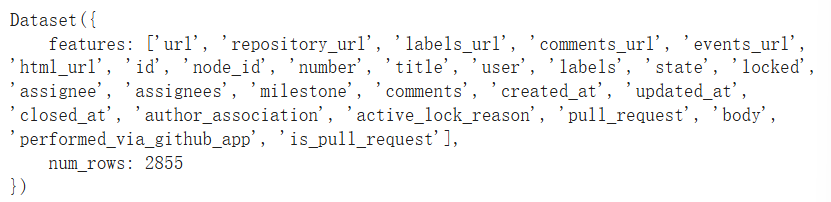

第一个任务是过滤掉拉取请求，因为这些请求很少用于回答用户查询，并且会在我们的搜索引擎中引入噪音。同时还可以过滤掉没有注释的行

In [ ]:
issues_dataset = issues_dataset.filter(
    lambda x: (x["is_pull_request"] == False and len(x["comments"]) > 0)
)
issues_dataset

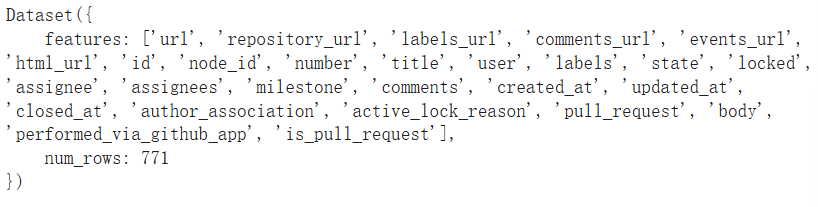

我们可以看到数据集中有很多列，其中大部分是构建搜索引擎时不需要的。从搜索的角度来看，信息最丰富的列式标题、正文、评论，而html_url为我们提供了返回原问题的链接。

我们用Dataset.remove_columns()函数删除其余部分

In [ ]:
columns = issues_dataset.column_names
columns_to_keep = ["title", "body", "html_url", "comments"]
columns_to_remove = set(columns_to_keep).symmetric_difference(columns) #set把列表转换为集合，集合会自动去重，并且没有顺序
issues_dataset = issues_dataset.remove_columns(columns_to_remove)

issues_dataset

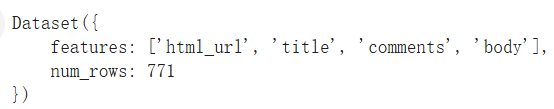

In [ ]:
#把 huggingface dataset对象转为pandas格式
issues_dataset.set_format("pandas")
df = issues_dataset[:]

In [ ]:
#tolist()将该元素（若是一个列表或数组）转换为Python的list
df["comments"][0].tolist()

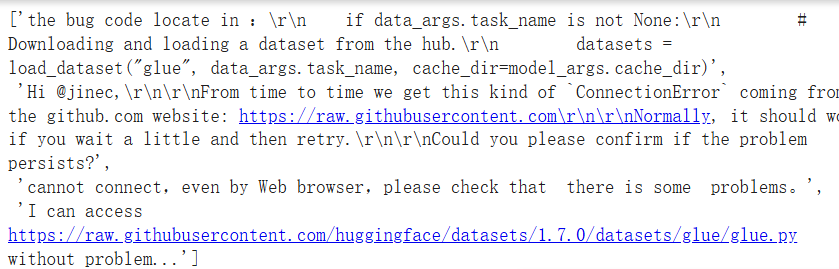

In [ ]:
#explode()用于将列中的列表或数组中的每个元素展开成单独的行
#ignore_index=True确保在展开后新的DataFrame中重新索引，避免出现重复的索引值。
#这样，新的DataFrame的行索引将从0开始递增
comments_df = df.explode("comments", ignore_index=True)
comments_df.head(4)

In [ ]:
#我们已经完成了需要再pandas中进行的任务，现在切换回dataset
from datasets import Dataset

comments_dataset = Dataset.from_pandas(comments_df)
comments_dataset

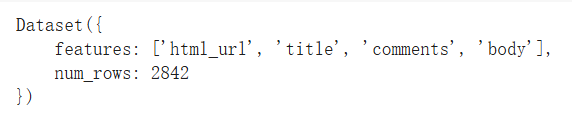

In [ ]:
#这段代码计算每条评论中的单词数，并将结果保存在一个名为 "comment_length" 的新列中，最终生成一个包含评论和其单词数的数据集。
comments_dataset = comments_dataset.map(
    lambda x: {"comment_length": len(x["comments"].split())}
)

In [ ]:
comments_dataset = comments_dataset.filter(lambda x: x["comment_length"] > 15)
comments_dataset

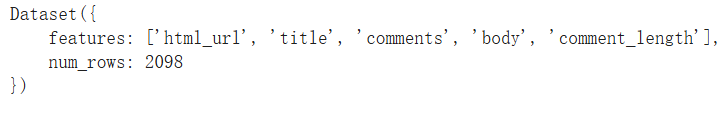

稍微清理了数据集后，让我们把问题标题、描述和评论连接到一个新的文本列中。像之前一样，我们将编写一个可以传递给Dataset.map的简单函数

In [ ]:
def concentrate_text(examples):
  return {
      "text": examples["title"]
      + " \n "
      + examples["body"]
      + " \n "
      +examples["comments"]
  }

comments_dataset = comments_dataset.map(concentrate_text)

In [ ]:
from transformers import AutoTokenizer, AutoModel

model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
import torch
#把模型移动到GPU设备上以便加速计算
device = torch.device("cuda")
model.to(device)

池化（Pooling）的目的是将多个token合并成一个固定大小的向量。

我们想把GitHub问题语料库中的每个条目表示为单个向量。因为我们需要某种方式池化或平均我们的token embeddings。

CLS池化是通过取出句子中的第一个token（[CLS]）的向量来表示整个句子，常用于分类任务等。

在Bert和Transformer模型中，设计了一个特殊的[CLS]token，它被放置在每个输入句子的最前面，这个token主要用于捕捉整个句子的全局语义信息。

我们对模型的输出执行CLS池化，我们只需要收集特殊的[CLS]token的最后一个隐藏状态。下面函数可以帮我们解决这个问题：



In [ ]:
def cls_pooling(model_output):
  return model_output.last_hidden_state[:, 0] #[:, 0]选择所有样本的第一个token，即[CLS]token

接下来，我们将创建一个helper function，它把文档列表分词，把张量放在GPU上，把它们喂给模型，最后将CLS池化应用于输出

In [ ]:
def get_embeddings(text_list):
  encoded_input = tokenizer(
      text_list, padding=True, truncation=True, return_tensors="pt"
  )
  encoded_input = {k:v.to(device) for k,v in encoded_input.items()}
  model_output = model(**encoded_input)
  return cls_pooling(model_output)

In [ ]:
embedding = get_embeddings(comments_dataset["text"][0])
embedding.shape

torch.Size([1, 768])

In [ ]:
#应用于全局
#.detach()用于从计算图中分离tensor
embedding_dataset = comments_dataset.map(
    lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
)

In [ ]:
#给数据集中的embedding列加一个FAISS索引，用于高效的进行相似度搜索和最近邻查询
embeddings_dataset.add_faiss_index(column="embeddings")

In [ ]:
#现在我们可以用FAISS进行最近邻查询了，来看个例子：
question = "How can I load a dataset offline?"
question_embedding = get_embeddings([question]).cpu().detach().numpy())
question_embedding.shape

torch.Size([1, 768])

我们现在有一个代表查询的768维向量，我们可以将其与整个语料库进行比较，以找到最相似的嵌入

In [ ]:
scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", question_embedding, k=5
)

In [ ]:
#用pandas对上面一段代码得到的结果进行排序
import pandas as pd

samples_df = pd.DataFrame.from_dict(samples)
samples_df["scores"] = scores
samples_df.fort_values("scores", ascending=True, inplace=True)

In [ ]:
#遍历samples_df数据框中的每一行并打印出每一行的相关信息
#iterrows() 返回每一行的索引（_）和该行的数据（row）。由于索引在这里不需要使用，所以常用 _ 来代替。
#print("=" * 50)：打印一个由 50 个等号（=）组成的分隔线，用于将每条记录分开，方便查看输出。
for _, row in samples_df.iterrows():
    print(f"COMMENT: {row.comments}")
    print(f"SCORE: {row.scores}")
    print(f"TITLE: {row.title}")
    print(f"URL: {row.html_url}")
    print("=" * 50)
    print()

In [ ]:
"""

COMMENT: Requiring online connection is a deal breaker in some cases unfortunately so it'd be great if offline mode is added similar to how `transformers` loads models offline fine.

@mandubian's second bullet point suggests that there's a workaround allowing you to use your offline (custom?) dataset with `datasets`. Could you please elaborate on how that should look like?
SCORE: 25.505046844482422
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824
==================================================

COMMENT: The local dataset builders (csv, text , json and pandas) are now part of the `datasets` package since #1726 :)
You can now use them offline
\`\`\`python
datasets = load_dataset("text", data_files=data_files)
\`\`\`

We'll do a new release soon
SCORE: 24.555509567260742
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824
==================================================

COMMENT: I opened a PR that allows to reload modules that have already been loaded once even if there's no internet.

Let me know if you know other ways that can make the offline mode experience better. I'd be happy to add them :)

I already note the "freeze" modules option, to prevent local modules updates. It would be a cool feature.

----------

> @mandubian's second bullet point suggests that there's a workaround allowing you to use your offline (custom?) dataset with `datasets`. Could you please elaborate on how that should look like?

Indeed `load_dataset` allows to load remote dataset script (squad, glue, etc.) but also you own local ones.
For example if you have a dataset script at `./my_dataset/my_dataset.py` then you can do
\`\`\`python
load_dataset("./my_dataset")
\`\`\`
and the dataset script will generate your dataset once and for all.

----------

About I'm looking into having `csv`, `json`, `text`, `pandas` dataset builders already included in the `datasets` package, so that they are available offline by default, as opposed to the other datasets that require the script to be downloaded.
cf #1724
SCORE: 24.14896583557129
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824
==================================================

COMMENT: > here is my way to load a dataset offline, but it **requires** an online machine
>
> 1. (online machine)
>
> ```
>
> import datasets
>
> data = datasets.load_dataset(...)
>
> data.save_to_disk(/YOUR/DATASET/DIR)
>
> ```
>
> 2. copy the dir from online to the offline machine
>
> 3. (offline machine)
>
> ```
>
> import datasets
>
> data = datasets.load_from_disk(/SAVED/DATA/DIR)
>
> ```
>
>
>
> HTH.


SCORE: 22.893993377685547
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824
==================================================

COMMENT: here is my way to load a dataset offline, but it **requires** an online machine
1. (online machine)
\`\`\`
import datasets
data = datasets.load_dataset(...)
data.save_to_disk(/YOUR/DATASET/DIR)
\`\`\`
2. copy the dir from online to the offline machine
3. (offline machine)
\`\`\`
import datasets
data = datasets.load_from_disk(/SAVED/DATA/DIR)
\`\`\`

HTH.
SCORE: 22.406635284423828
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824
==================================================

"""